# Installing phase

In [1]:
#Installing phase
!pip install scikit-learn-extra
!pip install factor_analyzer
!pip install pingouin

In [2]:
#Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statistics
from collections import Counter
import numpy as np
from pingouin import kruskal, read_dataset, pairwise_tests, chi2_independence
import math
from itertools import combinations

#Importing the Dataset

In [3]:
#Import Dataset
df = pd.read_csv("CleanDataset.csv")

In [4]:
df.head()

,age,gender,education,marital,income,phq_1,phq_2,phq_3,phq_4,phq_5,...,ccs_3,ccs_4,ccs_5,ccs_6,ccs_7,ccs_8,ccs_9,ccs_10,ccs_11,ccs_12
0,42.0,1,5.0,1,18000.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,4.0,3.0,6.0,4.0,0.0,0.0,3.0,5.0
1,51.0,3,18.0,1,23000.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,6.0,5.0,6.0,1.0,4.0,0.0,3.0,0.0
2,40.0,0,8.0,1,10000.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6.0,6.0,6.0,1.0,0.0,2.0,1.0,6.0,3.0
3,19.0,0,25.0,5,31000.0,2.0,1.0,0.0,0.0,2.0,...,0.0,4.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0
4,42.0,2,13.0,1,40000.0,0.0,1.0,0.0,0.0,1.0,...,0.0,6.0,0.0,6.0,0.0,1.0,1.0,0.0,5.0,2.0


# Utils

In [5]:
#Replace nominal data with dummies and returns a new dataset
def preprocess_nominalVariable(df):
  df_one = pd.get_dummies(df["gender"])
  df_one.rename(
    columns={0: "male", 1: "female", 2: "non-binary", 3: "prefer-not-to-say"},
    inplace=True,
  )
  df_two = pd.get_dummies(df["marital"])
  df_two.rename(
    columns={0: "single", 1: "married", 2: "divorced", 3: "widowed", 4: "separeted", 5: "other"},
    inplace=True,
  )
  df_new = pd.concat((df_one, df_two, df), axis=1)
  df_new = df_new.drop(["gender"], axis=1)
  df_new = df_new.drop(["marital"], axis=1)
  return df_new

In [6]:
#Standardization's function
def compute_scaled_df(df, cols_to_scale):
    scaled_df = df.copy()
    features = scaled_df[cols_to_scale]
    scaler = RobustScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_df[cols_to_scale] = features
    return scaled_df, scaler


In [7]:
def scaled(df, cols_to_scale, scaler_type='robust'):
    scaled_df = df.copy()
    features = scaled_df[cols_to_scale]

    if scaler_type == 'robust':
        scaler = RobustScaler().fit(features.values)
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler().fit(features.values)
    else:
        raise ValueError("Invalid scaler_type. Use 'robust' or 'minmax'.")

    features = scaler.transform(features.values)
    scaled_df[cols_to_scale] = features

    return scaled_df, scaler

In [8]:
#Function that plots the PCA
def check_PCA_components(df, cols_to_scale):
  scaled_df, scaler = compute_scaled_df(df, cols_to_scale)
  pca = PCA()
  pca.fit(scaled_df)
  plt.figure(figsize=(10,8))
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(),marker='o', linestyle = '--')
  plt.title('Explained Variance by Components')
  plt.xlabel('n_components')
  plt.ylabel('Explained variance by Components')

In [9]:
#Calculate the PCA
def compute_PCA_scores(df, n_components, cols_to_scale):
  scaled_df, scaler = compute_scaled_df(df, cols_to_scale)
  pca = PCA(n_components=n_components)
  pca.fit(scaled_df)
  print(pca.explained_variance_ratio_)
  print("Number of components: " + str(n_components) + "  Explained Variance: " + str(sum(pca.explained_variance_ratio_)))
  return pca.transform(scaled_df)

In [10]:
#Returns wcss and avg_silhoutte for different cluster numbers inside Kmeans range
def compute_kmeans_metrics(scores_matrix, range):
  wcss = []
  avg_sil = []
  for i in range:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scores_matrix)
    wcss.append(kmeans.inertia_)
    avg_sil.append(silhouette_score(scores_matrix, kmeans.labels_))
    #print(silhouette_score(scores_matrix, kmeans_pca.labels_))
  return wcss, avg_sil

In [11]:
#Returns wcss and avg_silhoutte for different cluster numbers within range KMedoids
def compute_kmed_metrics(scores_matrix, range):
  wcss = []
  avg_sil = []
  for i in range:
    kmed = KMedoids(n_clusters = i, init = 'k-medoids++', max_iter = 10000, method='pam', random_state = 42)
    kmed.fit(scores_matrix)
    wcss.append(kmed.inertia_)
    avg_sil.append(silhouette_score(scores_matrix, kmed.labels_))
    #print(silhouette_score(scores_matrix, kmed_pca.labels_))
  return wcss, avg_sil

In [12]:
#Returns avg_silhoutte for different cluster numbers within range hierical agglomerative
def compute_agglomerative_metrics(scores_matrix, range):
  avg_sil = []
  for i in range:
    agglom = AgglomerativeClustering(n_clusters = i, affinity='euclidean', linkage='complete')
    agglom.fit(scores_matrix)
    avg_sil.append(silhouette_score(scores_matrix, agglom.labels_))
    #print(silhouette_score(scores_matrix, kmed_pca.labels_))
  return avg_sil

In [13]:
#Plotta la wss calcolata con le funzioni compute_kmeans_metrics e compute_kmed_metrics
def wss_plot(to_plot, range):
  plt.figure(figsize = (10, 8))
  plt.title('WCSS')
  plt.xlabel("number of clusters")
  plt.ylabel("wcss")
  for wcss in to_plot:
    plt.plot(range, wcss[0], marker='o', linestyle = '--', label = wcss[1])
  plt.legend()
  plt.show()

In [14]:
#Plot silhouette calculated with compute_kmeans_metrics and compute_kmed_metrics functions
def silhouette_plot(to_plot, range):
  plt.figure(figsize = (10, 8))
  plt.title('Silhouette')
  plt.xlabel("number of clusters")
  plt.ylabel("silhouette")
  for sil in to_plot:
    plt.plot(range, sil[0], marker='o', linestyle = '--', label = sil[1])
  plt.legend()
  plt.show()

In [15]:
#Flatten a list
def flatten_list(lst):
  return [item for sublist in lst for item in sublist]

In [16]:
#Calculate Expected frequencies of the table
def calculate_expected_frequencies(table):
  a = table.values
  return pd.DataFrame((a.sum(0)*a.sum(1)[:,None])/a.sum(),
             columns=table.columns, index=table.index)

In [17]:
#Depth-first search used to perform the Fiscer exact test
def _dfs(mat, pos, r_sum, c_sum, p_0, p):

    (xx, yy) = pos
    (r, c) = (len(r_sum), len(c_sum))

    mat_new = []

    for i in range(len(mat)):
        temp = []
        for j in range(len(mat[0])):
            temp.append(mat[i][j])
        mat_new.append(temp)

    if xx == -1 and yy == -1:
        for i in range(r-1):
            temp = r_sum[i]
            for j in range(c-1):
                temp -= mat_new[i][j]
            mat_new[i][c-1] = temp
        for j in range(c-1):
            temp = c_sum[j]
            for i in range(r-1):
                temp -= mat_new[i][j]
            mat_new[r-1][j] = temp
        temp = r_sum[r-1]
        for j in range(c-1):
            temp -= mat_new[r-1][j]
        if temp <0:
            return
        mat_new[r-1][c-1] = temp

        p_1 = 1
        for x in r_sum:
            p_1 *= math.factorial(x)
        for y in c_sum:
            p_1 *= math.factorial(y)

        n = 0
        for x in r_sum:
            n += x
        p_1 /= math.factorial(n)

        for i in range(len(mat_new)):
            for j in range(len(mat_new[0])):
                p_1 /= math.factorial(mat_new[i][j])
        if p_1 <= p_0 + 0.00000001:
            #print(mat_new)
            #print(p_1)
            p[0] += p_1
    else:
        max_1 = r_sum[xx]
        max_2 = c_sum[yy]
        for j in range(c):
            max_1 -= mat_new[xx][j]
        for i in range(r):
            max_2 -= mat_new[i][yy]
        for k in range(min(max_1,max_2)+1):
            mat_new[xx][yy] = k
            if xx == r-2 and yy == c-2:
                pos_new = (-1, -1)
            elif xx == r-2:
                pos_new = (0, yy+1)
            else:
                pos_new = (xx+1, yy)
            _dfs(mat_new, pos_new, r_sum, c_sum, p_0, p)

In [18]:
#Calculate the p-value for the Fiscer exact test
def fisher_exact(table, n_columns, n_row):

    row_sum = []
    col_sum = []

    for i in range(n_columns):
        temp = 0
        for j in range(n_row):
            temp += table.iloc[i,j]
        row_sum.append(temp)

    for j in range(n_row):
        temp = 0
        for i in range(n_columns):
            temp += table.iloc[i,j]
        col_sum.append(temp)

    mat = [[0] * len(col_sum)] * len(row_sum)
    pos = (0, 0)

    p_0 = 1

    for x in row_sum:
        p_0 *= math.factorial(x)
    for y in col_sum:
        p_0 *= math.factorial(y)

    n = 0
    for x in row_sum:
        n += x
    p_0 /= math.factorial(n)

    for i in range(n_columns):
        for j in range(n_row):
            p_0 /= math.factorial(table.iloc[i,j])

    p = [0]
    _dfs(mat, pos, row_sum, col_sum, p_0, p)

    return p[0]

# Features Reduction

## Sum the features related to the same topic

In [19]:
df_f = df.copy()

In [20]:
#Replace nominal data with dummies
df_f = preprocess_nominalVariable(df_f)

In order to perform feature reduction we decide to sum the features related to the same topic

In [21]:
# Somma delle colonne e crea una nuova colonna 'somma'
df_f['phq'] = df_f[['phq_1', 'phq_2', 'phq_3', 'phq_4', 'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9']].sum(axis=1)

# Rimuovi le colonne originali
df_f.drop(['phq_1', 'phq_2', 'phq_3', 'phq_4', 'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9'], axis=1, inplace=True)

In [22]:
# Somma delle colonne e crea una nuova colonna 'somma'
df_f['gad'] = df_f[['gad_1', 'gad_2', 'gad_3', 'gad_4', 'gad_5', 'gad_6', 'gad_7']].sum(axis=1)

# Rimuovi le colonne originali
df_f.drop(['gad_1', 'gad_2', 'gad_3', 'gad_4', 'gad_5', 'gad_6', 'gad_7'], axis=1, inplace=True)

In [23]:
# Somma delle colonne e crea una nuova colonna 'somma'
df_f['eheals'] = df_f[['eheals_1', 'eheals_2', 'eheals_3', 'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7', 'eheals_8']].sum(axis=1)

# Rimuovi le colonne originali
df_f.drop(['eheals_1', 'eheals_2', 'eheals_3', 'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7', 'eheals_8'], axis=1, inplace=True)

In [24]:
#Somma delle colonne e crea una nuova colonna 'somma'
df_f['heas'] = df_f[['heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6', 'heas_7', 'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12', 'heas_13']].sum(axis=1)

# Rimuovi le colonne originali
df_f.drop(['heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6', 'heas_7', 'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12', 'heas_13'], axis=1, inplace=True)

In [25]:
# Somma delle colonne e crea una nuova colonna 'somma'
df_f['ccs'] = df_f[['ccs_1', 'ccs_2', 'ccs_3', 'ccs_4', 'ccs_5', 'ccs_6', 'ccs_7', 'ccs_8', 'ccs_9', 'ccs_10', 'ccs_11', 'ccs_12']].sum(axis=1)

# Rimuovi le colonne originali
df_f.drop(['ccs_1', 'ccs_2', 'ccs_3', 'ccs_4', 'ccs_5', 'ccs_6', 'ccs_7', 'ccs_8', 'ccs_9', 'ccs_10', 'ccs_11', 'ccs_12'], axis=1, inplace=True)

In [26]:
df_f, scaler = compute_scaled_df(df_f, ['age', 'education', 'income', 'phq', 'gad', 'eheals', 'heas', 'ccs'])

## PCA

In [27]:
df_pca = df.copy()

In [28]:
df_pca = preprocess_nominalVariable(df_pca)

In [29]:
cols_to_scale = ['age', 'education', 'income', 'phq_1', 'phq_2',
       'phq_3', 'phq_4', 'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9', 'gad_1',
       'gad_2', 'gad_3', 'gad_4', 'gad_5', 'gad_6', 'gad_7', 'eheals_1',
       'eheals_2', 'eheals_3', 'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7',
       'eheals_8', 'heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6',
       'heas_7', 'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12',
       'heas_13', 'ccs_1', 'ccs_2', 'ccs_3', 'ccs_4', 'ccs_5', 'ccs_6',
       'ccs_7', 'ccs_8', 'ccs_9', 'ccs_10', 'ccs_11', 'ccs_12']

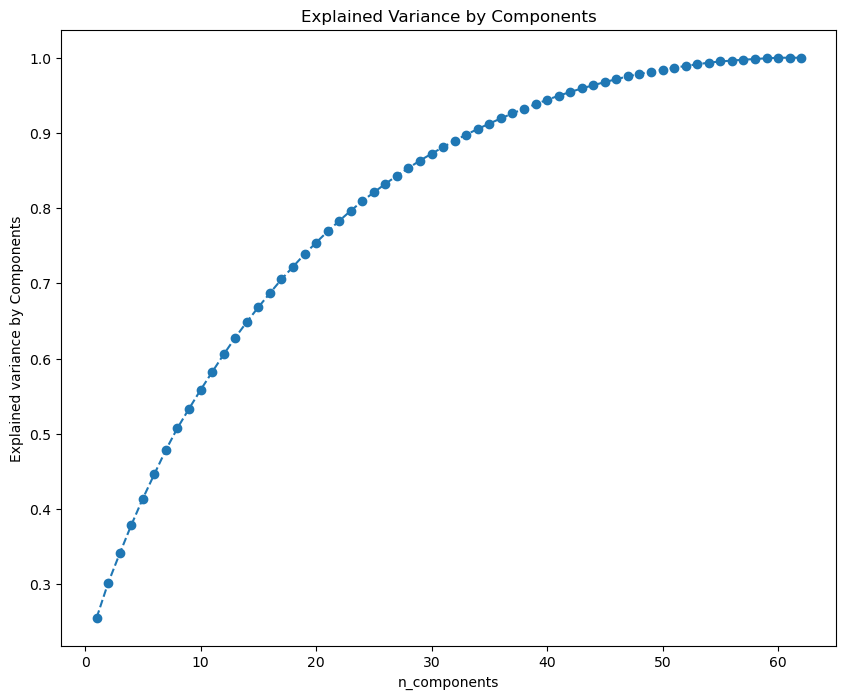

In [30]:
#Plot the cumulative Explained Variance
check_PCA_components(df_pca, cols_to_scale)

In [31]:
#Compute the PCA scores
pca_scores = compute_PCA_scores(df_pca, 21, cols_to_scale)

[0.25537306 0.04629689 0.03912883 0.03774549 0.03525742 0.03257894
 0.03224078 0.02899289 0.02568737 0.02493499 0.02377565 0.02340932
 0.02241391 0.02071109 0.01971708 0.01863948 0.01840147 0.01672292
 0.01667699 0.01546481 0.01480786]
Number of components: 21  Explained Variance: 0.7689772311870914


## Factorial Analysis

In [32]:
df_fact = df.copy()

Before performing factor analysis, we need to evaluate the “factorability” of our dataset.


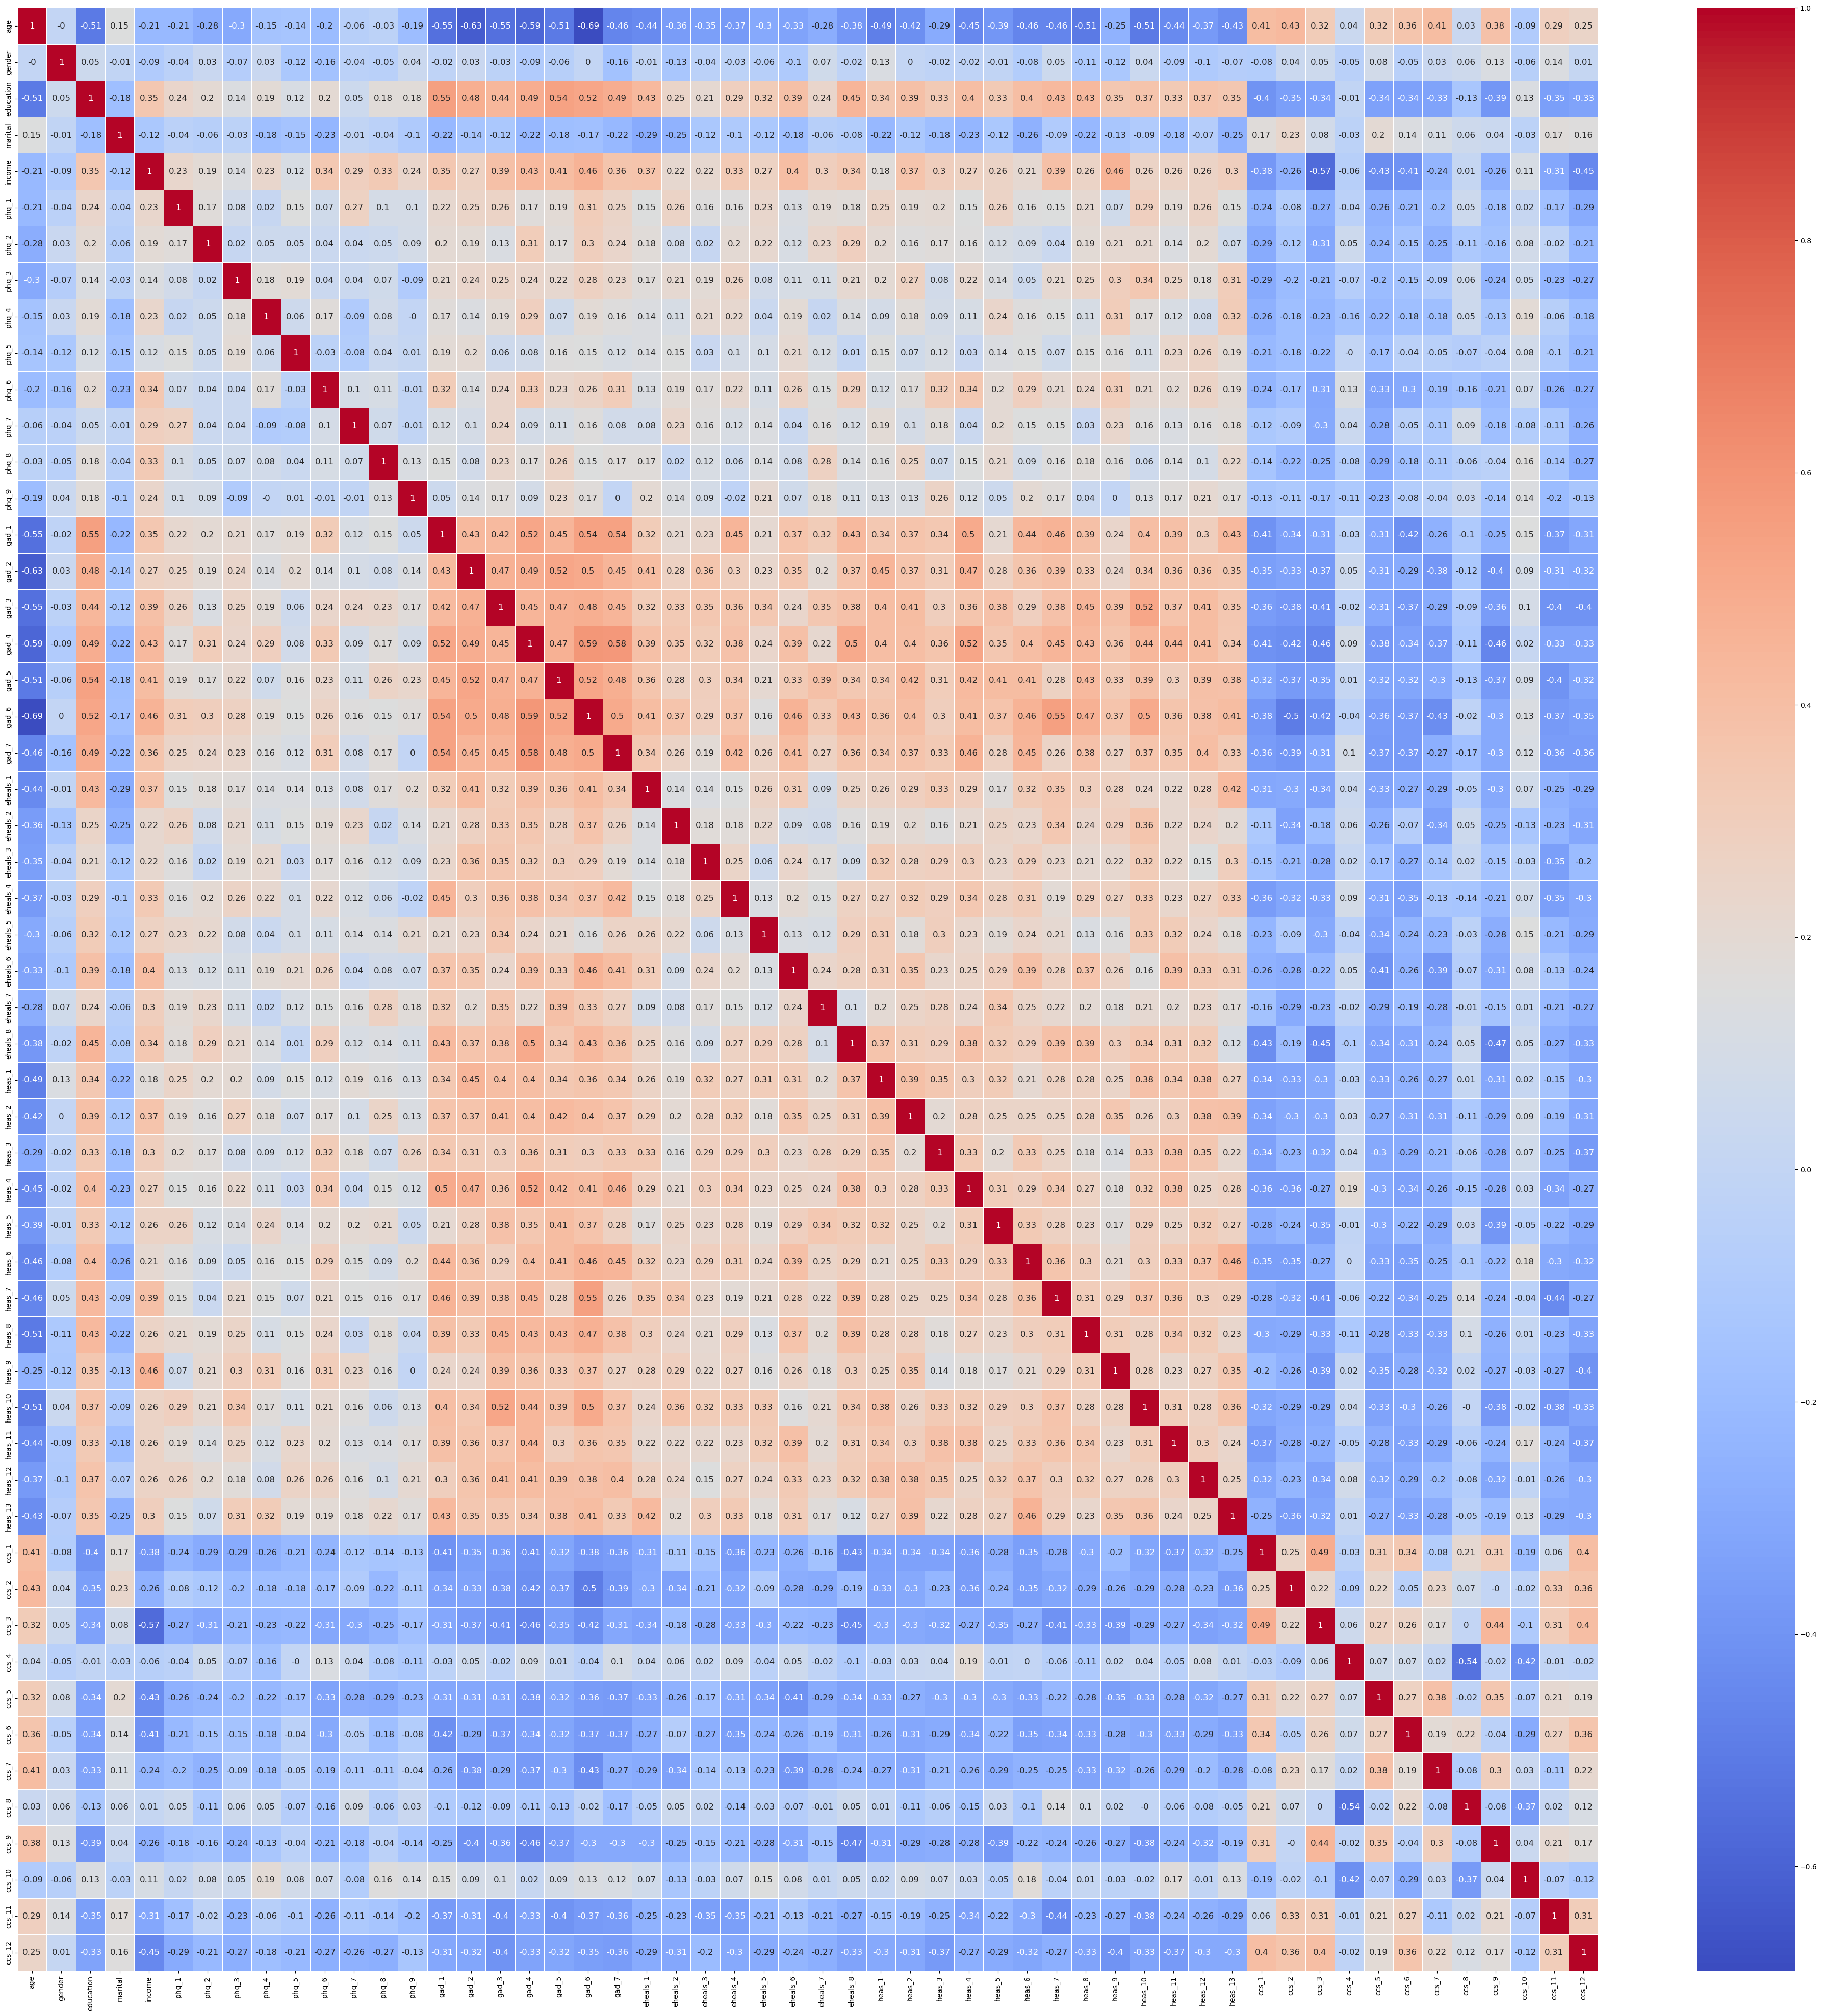

In [33]:
#We can visualise the correlation using a heatmap in Seaborn
X = df_fact
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (50,50))
sns.heatmap(data=X.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

First parameter: the correlation matrix between all variables in dataset "df_Imputer" must be greater than 0.3

In [34]:
correlation_matrix = X.corr()
threshold = 0.3
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Stampa le coppie di variabili fortemente correlate
for pair in highly_correlated_pairs:
    print(f"Variabili correlate: {pair[0]} e {pair[1]}, Correlazione: {pair[2]}")

Variabili correlate: education e age, Correlazione: -0.5131318231465499
Variabili correlate: income e education, Correlazione: 0.3478369743244519
Variabili correlate: phq_6 e income, Correlazione: 0.34087001990635263
Variabili correlate: phq_8 e income, Correlazione: 0.3309856541937072
Variabili correlate: gad_1 e age, Correlazione: -0.5474754445178934
Variabili correlate: gad_1 e education, Correlazione: 0.5513145657371707
Variabili correlate: gad_1 e income, Correlazione: 0.35028580070093274
Variabili correlate: gad_1 e phq_6, Correlazione: 0.324008470756519
Variabili correlate: gad_2 e age, Correlazione: -0.631031488164436
Variabili correlate: gad_2 e education, Correlazione: 0.48292007353746064
Variabili correlate: gad_2 e gad_1, Correlazione: 0.43315269668368334
Variabili correlate: gad_3 e age, Correlazione: -0.5473441971851583
Variabili correlate: gad_3 e education, Correlazione: 0.44194681980818373
Variabili correlate: gad_3 e income, Correlazione: 0.39223049784680775
Variabili

Bartlett's test: Verify that the p-value is much less than 0.5 so that the test is statistically significant

In [35]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(X)
chi_square_value, p_value

(3858.2052530782134, 1.2054262589127225e-221)

Kayser-Mayer-Olkin test: Verify that the global KMO has values >0.6

In [36]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(X)

print("KMO globale:", kmo_model)

KMO globale: 0.820511347000036


In [37]:
from factor_analyzer import FactorAnalyzer
factor_model = FactorAnalyzer(n_factors=20, rotation="varimax")
factor_model.fit(X)
eigenvalues, _ = factor_model.get_eigenvalues()
# count eigenvalues > 1
number_of_factors = sum(eigenvalues > 1)
factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation="promax")
factor_model.fit(X)

FactorAnalyzer(n_factors=15, rotation_kwargs={})

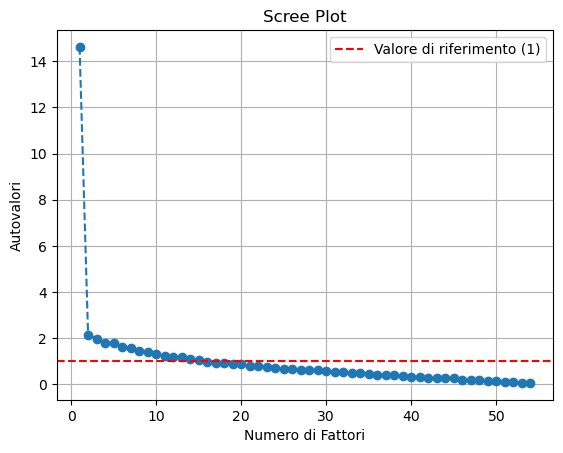

In [38]:
import matplotlib.pyplot as plt

# factor_model è già stato addestrato con il numero di fattori appropriato
eigenvalues, _ = factor_model.get_eigenvalues()

# Creazione dello scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--', label='Valore di riferimento (1)')
plt.xlabel("Numero di Fattori")
plt.ylabel("Autovalori")
plt.title("Scree Plot")
plt.grid()
plt.legend()
plt.show()

In [39]:
number_of_factors

15

In [40]:
extracted_factor = factor_model.loadings_
extracted_factor

array([[-1.09269286e+00, -6.97255703e-02,  1.80107323e-02,
         9.84594039e-02,  2.54620445e-01,  4.85970593e-02,
        -1.78620014e-01,  1.31447741e-01, -2.08919112e-02,
         2.28001852e-02, -2.08239096e-02, -1.45772130e-01,
         2.09935913e-02, -3.38119779e-02,  2.11901983e-02],
       [ 6.79468302e-02, -1.91847363e-01,  6.40742354e-02,
         1.12918771e-01,  2.73163704e-02, -2.28371799e-02,
         7.31028491e-01, -1.69757659e-02,  1.36706811e-01,
         6.81419511e-02,  4.11926268e-02, -4.00805292e-03,
        -1.92675692e-01,  1.00729902e-01, -2.54916706e-03],
       [ 6.78461396e-01,  1.03794883e-01, -5.24474454e-02,
        -3.31693466e-02,  5.28587724e-02, -1.86342130e-01,
         2.35584745e-02,  8.19600257e-04,  1.39408087e-01,
         1.57120327e-02, -2.92304130e-02,  3.44546143e-02,
        -2.84653940e-02,  2.00007872e-01,  2.95599795e-02],
       [ 2.93345674e-02,  1.48743419e-01, -1.93269415e-01,
        -6.29933046e-02,  5.63136837e-02,  1.43942191

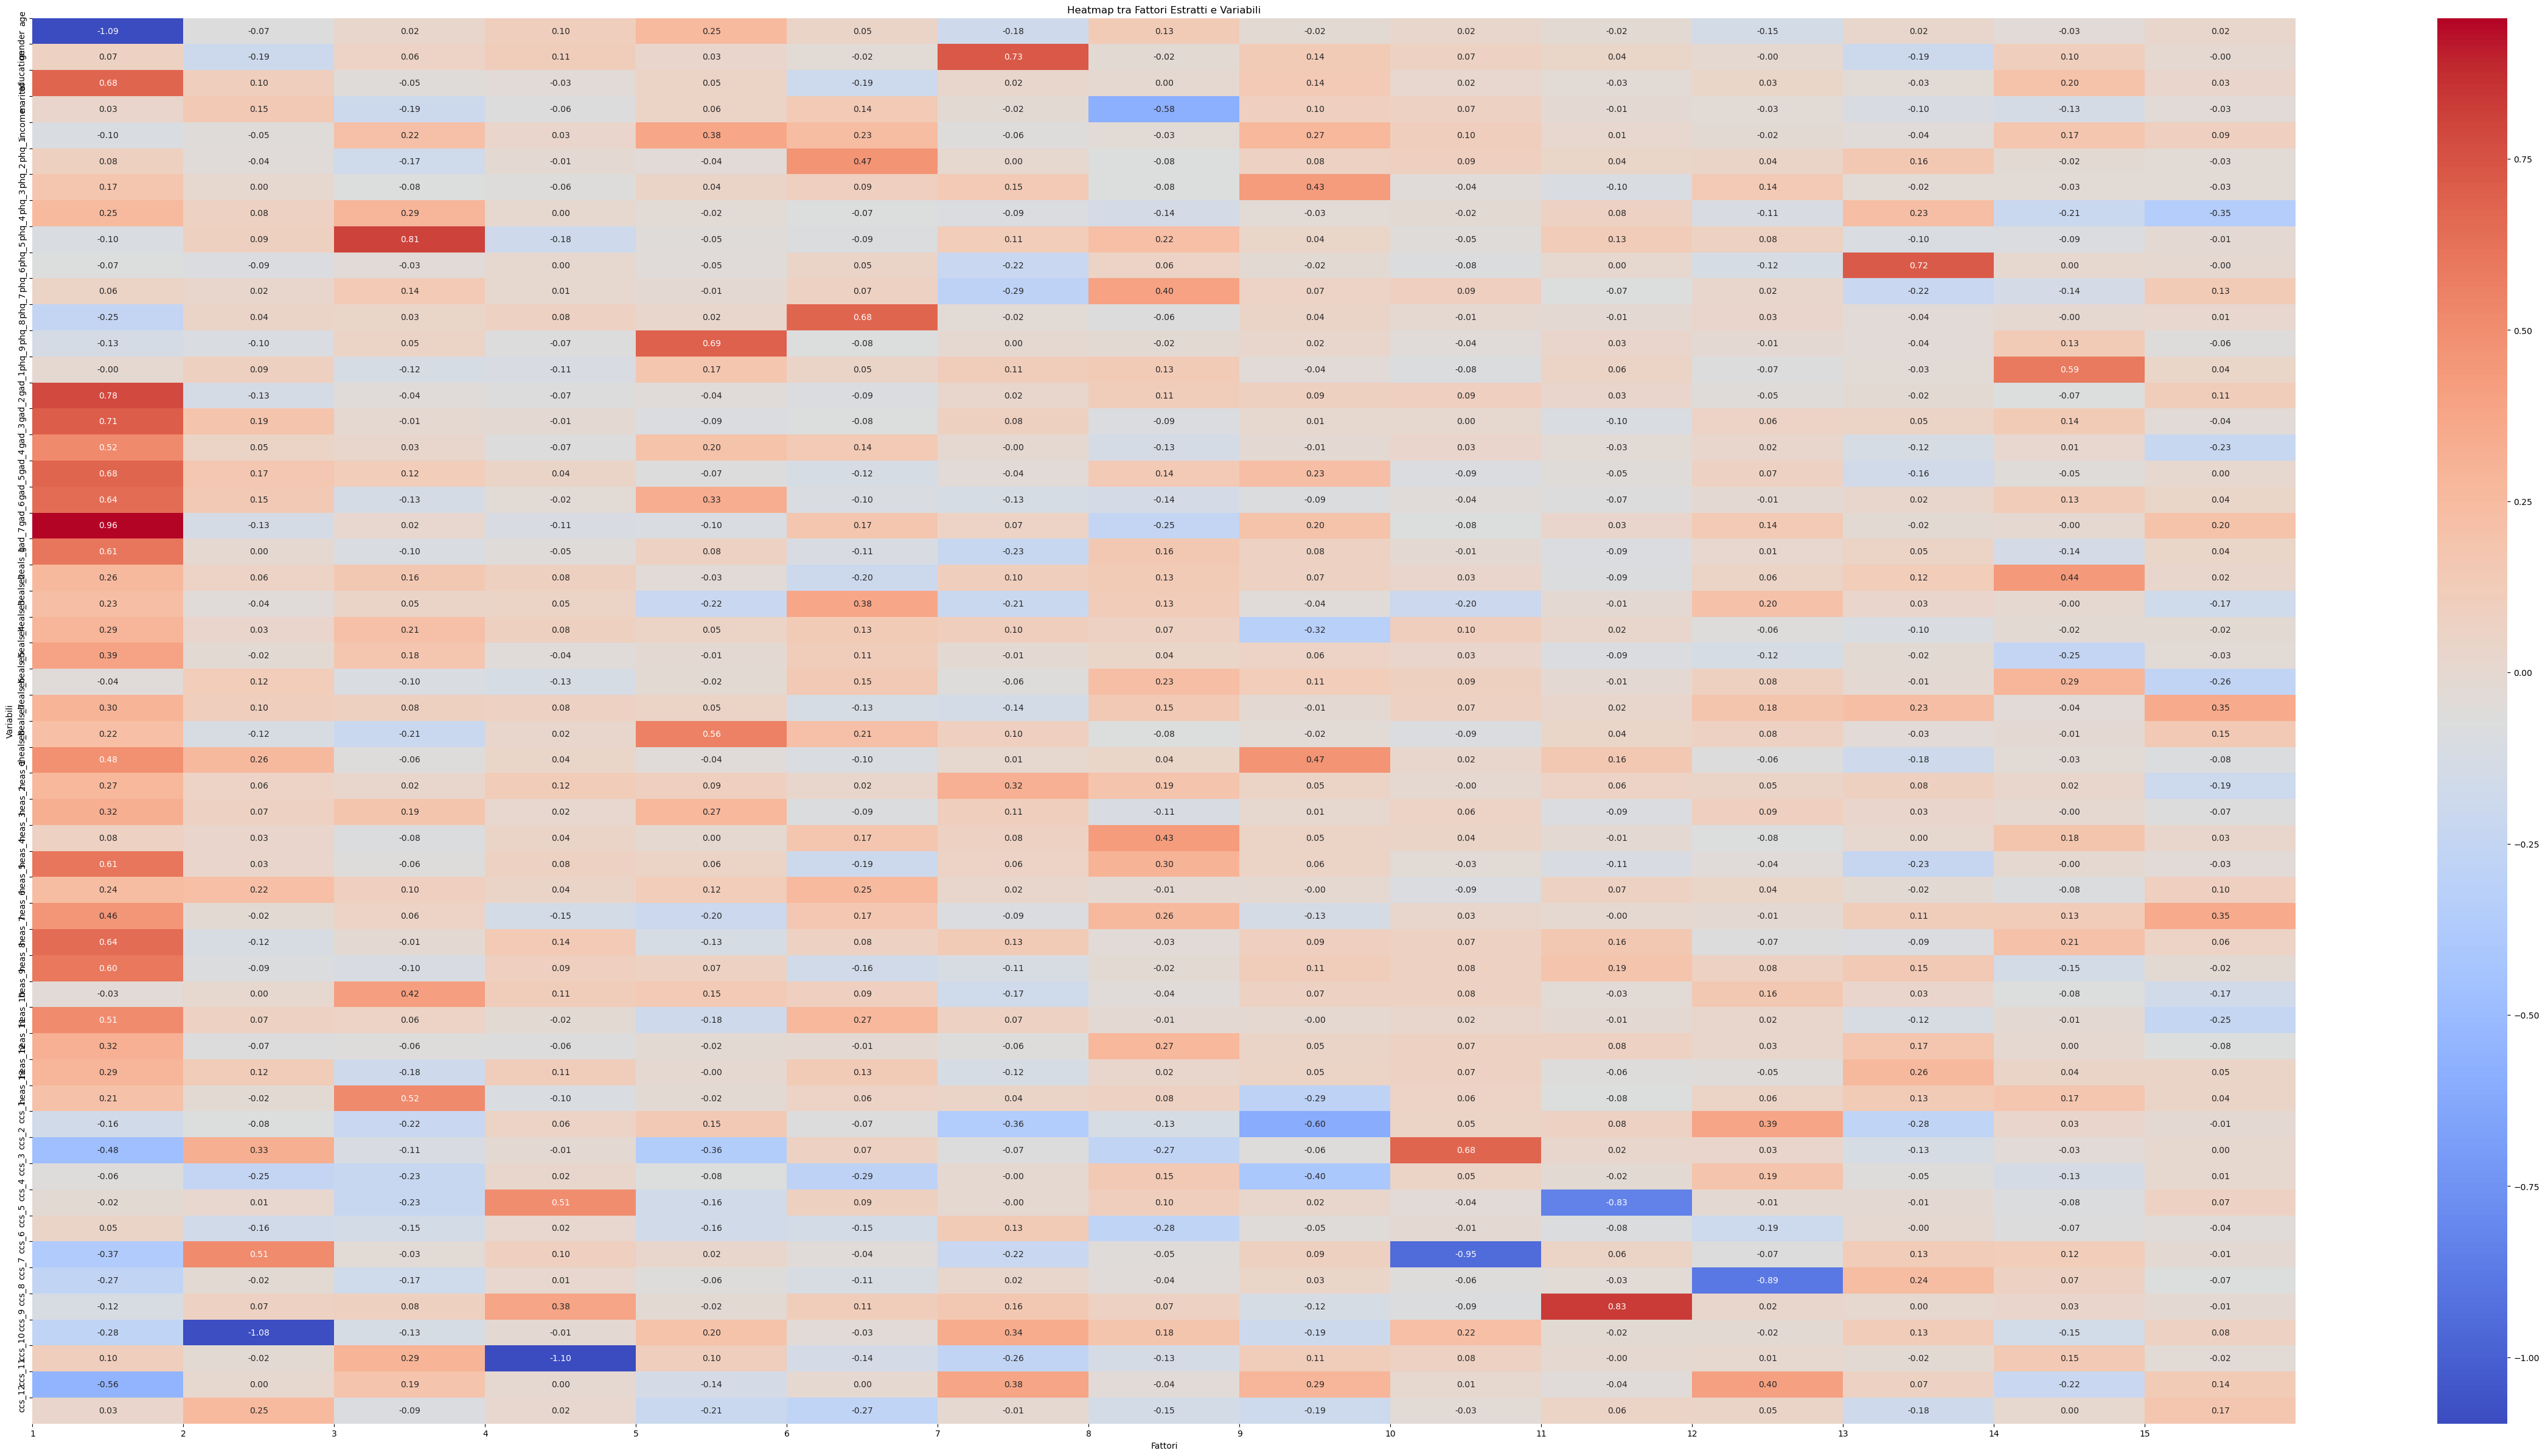

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che le dimensioni delle matrici siano compatibili
# 'fattori_estratti' dovrebbe avere il numero di colonne corrispondente al numero di colonne in 'df'

# Crea una heatmap utilizzando Seaborn
plt.figure(figsize=(60, 30))  # Imposta le dimensioni della figura

# Utilizza il metodo heatmap di Seaborn
sns.heatmap(extracted_factor, annot=True, cmap='coolwarm', fmt='.2f')

# Imposta gli assi
plt.title('Heatmap tra Fattori Estratti e Variabili')
plt.xlabel('Fattori')
plt.ylabel('Variabili')

# Etichettatura degli assi
plt.xticks(range(extracted_factor.shape[1]), range(1, extracted_factor.shape[1] + 1))
plt.yticks(range(len(X.columns)),X.columns)

# Mostra la heatmap
plt.show()

# Clustering

For each type of feature reduction we tried 3 different clustering techniques: **Kmeans**, **Kmedoids** and **Hierarchical Agglomerative**.

In [42]:
wcss_pca_kmeans, sil_pca_kmeans = compute_kmeans_metrics(pca_scores, range(2, 20))
wcss_pca_kmed, sil_pca_kmed = compute_kmed_metrics(pca_scores, range(2, 20))
sil_pca_aggl = compute_agglomerative_metrics(pca_scores, range(2, 20))

In [43]:
wcss_sum_kmeans, sil_sum_kmeans = compute_kmeans_metrics(df_f, range(2, 20))
wcss_sum_kmed, sil_sum_kmed = compute_kmed_metrics(df_f, range(2, 20))
sil_sum_aggl = compute_agglomerative_metrics(df_f, range(2, 20))

In [44]:
wcss_fact_kmeans, sil_fact_kmeans = compute_kmeans_metrics(extracted_factor, range(2, 20))
wcss_fact_kmed, sil_fact_kmed = compute_kmed_metrics(extracted_factor, range(2, 20))
sil_fact_aggl = compute_agglomerative_metrics(extracted_factor, range(2, 20))

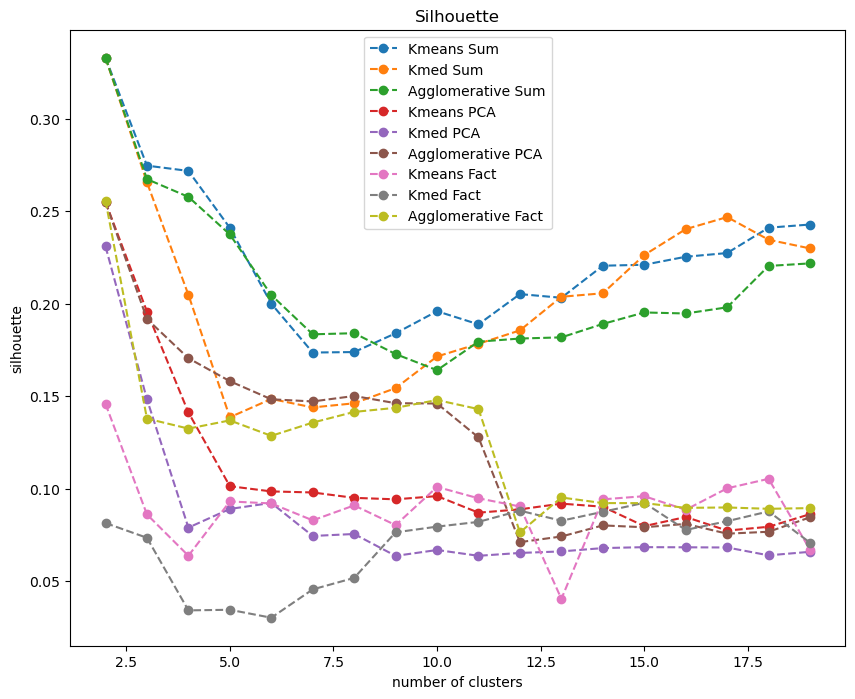

In [45]:
#Plot the silhouette results
pairs = []
pairs.append((sil_sum_kmeans, 'Kmeans Sum'))
pairs.append((sil_sum_kmed, 'Kmed Sum'))
pairs.append((sil_sum_aggl, 'Agglomerative Sum'))
pairs.append((sil_pca_kmeans, 'Kmeans PCA'))
pairs.append((sil_pca_kmed, 'Kmed PCA'))
pairs.append((sil_pca_aggl, 'Agglomerative PCA'))
pairs.append((sil_fact_kmeans, 'Kmeans Fact'))
pairs.append((sil_fact_kmed, 'Kmed Fact'))
pairs.append((sil_fact_aggl, 'Agglomerative Fact'))
silhouette_plot(pairs, range(2, 20))

Based on silhouette values and the results in creating personas, we decided to use the **sum of features** as a method for feature reduction and **K-means** for clustering.

## Final Clustering Result

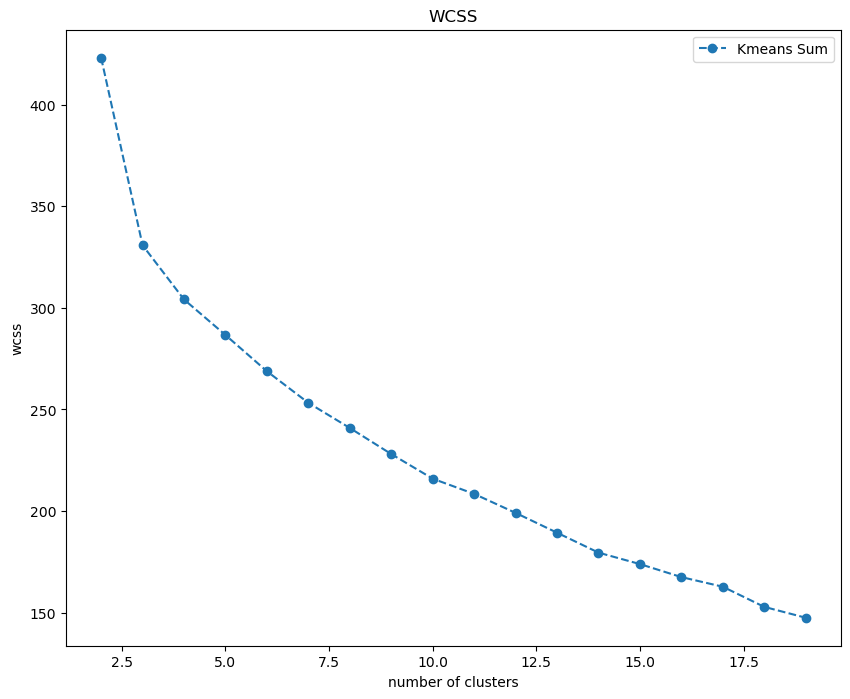

In [46]:
pairs = []
pairs.append((wcss_sum_kmeans, 'Kmeans Sum'))
wss_plot(pairs, range(2, 20))

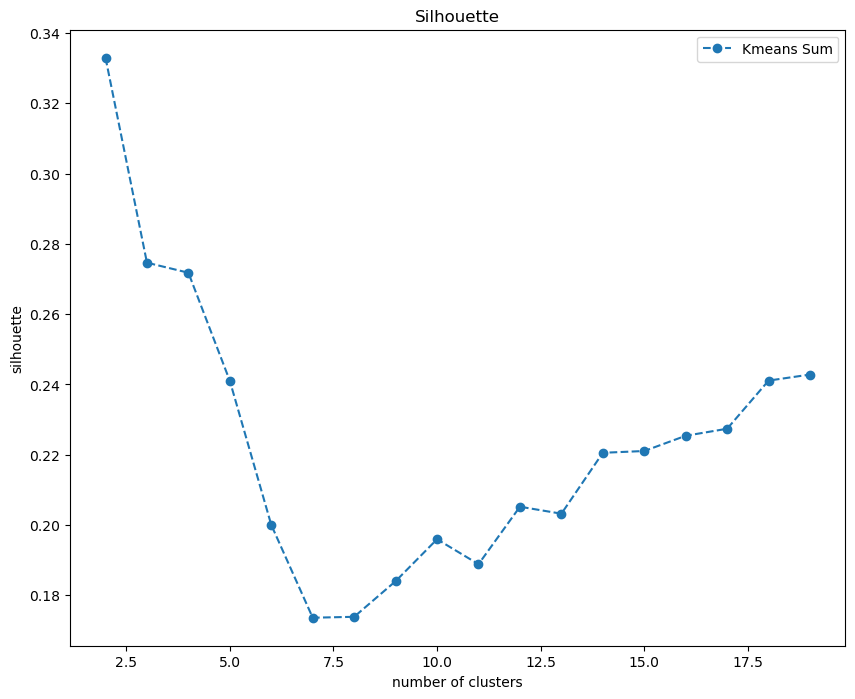

In [47]:
pairs = []
pairs.append((sil_sum_kmeans, 'Kmeans Sum'))
silhouette_plot(pairs, range(2, 20))

Based on the value of the silhoutte and of the wcss the suggested number of cluster to use is 3

In [49]:
# Specifies the desired number of clusters (n_clusters)
n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
kmeans.fit(df_f)

# Get cluster labels for each row in the dataset X
labels = kmeans.labels_

# Ottieni i centroidi dei cluster
centroids = kmeans.cluster_centers_


In [50]:
#silhouettes analysis
km = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
y_km = km.fit_predict(df_f)

import numpy as np
cluster_labels = np.unique(y_km)

In [51]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_vals = silhouette_samples(df_f,
                                     y_km,
                                     metric='euclidean')

For n_clusters = 3 The average silhouette_score is : 0.274641315372255


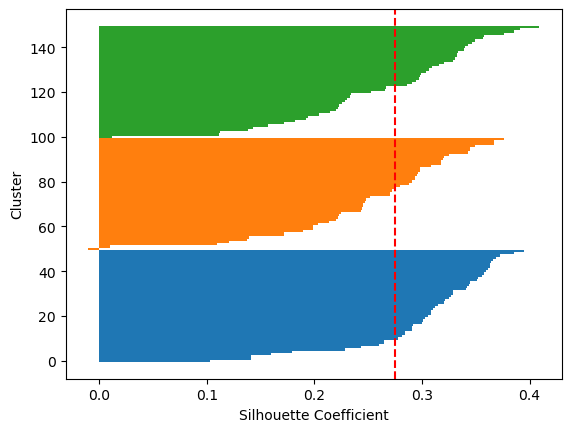

In [52]:
import matplotlib.pyplot as plt
def silh(silhouette_val,y):
    y_ax_lower, y_ax_upper=0,0

    for i in np.unique(y):
        c_silhouette_vals = silhouette_vals[y_km==i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='red',linestyle='--')
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.show()

silhouette_avg = silhouette_score(df_f, y_km)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

silh(silhouette_vals,y_km)

# Statistical Analysis

In [53]:
df_in = df.copy()

In [54]:
#Adds new column 'cluster_labels'
df_f['cluster_label'] = pd.Series(km.labels_, index=df_f.index)

In [55]:
#Adds new column 'cluster_labels' also to the original dataset
df_in['cluster_label'] = pd.Series(km.labels_, index=df_in.index)

In [56]:
df_in.head(1)

,age,gender,education,marital,income,phq_1,phq_2,phq_3,phq_4,phq_5,...,ccs_4,ccs_5,ccs_6,ccs_7,ccs_8,ccs_9,ccs_10,ccs_11,ccs_12,cluster_label
0,42.0,1,5.0,1,18000.0,0.0,0.0,1.0,0.0,0.0,...,1.0,4.0,3.0,6.0,4.0,0.0,0.0,3.0,5.0,0


## Ordinal and Quantitative variables

### Assumption to use the Kruskal-Wallis test

Non-parametric statistical tests become the appropriate choice when:

1. The variables under examination exhibit clear deviations from normality (or show strong asymmetry or more than one peak).

2. The sample size available is too small to determine whether the data follows a normal distribution.

3. My observations are represented by ordinal and quantitative variables.

Therefore, if my variables are ordinal in nature opting for non-parametric tests is justified.

### Kruskal-Wallis Test

In [57]:
from scipy.stats import kruskal

for col in df_f.columns:
    if col not in ['cluster_label', 'male', 'female', 'non-binary', 'prefer-not-to-say', 'single', 'married', 'divorced', 'widowed', 'separeted', 'other']:
        data_grouped_by_cluster = [df_f[col][df_f['cluster_label'] == label] for label in df_f['cluster_label'].unique()]
        p_value = kruskal(*data_grouped_by_cluster).pvalue
        print(col + ': ' + str(p_value))


age: 1.9371217861857743e-22
education: 6.304869904807864e-16
income: 7.691407599381742e-18
phq: 1.28928155710625e-22
gad: 1.2884347526434395e-29
eheals: 1.7119939164512287e-29
heas: 1.5711634199925178e-29
ccs: 1.7927055804569654e-29


The p-values we obtained from the Kruskal-Wallis tests for various variables indicate that there are statistically
significant differences in the distributions of these variables among the different groups defined by the
clustering labels in our DataFrame. In other words, the variations among groups for the variables "age," "education," "income," "phq," "gad," "eheals," "heas," and "ccs" are not random and can be considered
statistically meaningful. These results suggest that the variables have a significant impact on the groupings
identified by the clustering labels in our dataset.

### Pairwise Mann-Whitney U tests

In [58]:
#Multiple Mann-Whitney U tests between groups with Bonferroni correction
for col in df_f.columns:
  if(col not in ['cluster_label', 'male', 'female', 'non-binary',	'prefer-not-to-say',	'single',	'married',	'divorced',	'widowed',	'separeted',	'other']):
    print(col + ": ")
    display(pairwise_tests(df_f, col, 'cluster_label', parametric = False, padjust = 'bonf'))
    print("\n")

age: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,2500.0,two-sided,6.667545e-18,2.000264e-17,bonf,3.389435
1,cluster_label,0,2,False,False,1403.0,two-sided,2.920449e-01,8.761347e-01,bonf,0.178148
2,cluster_label,1,2,False,False,0.0,two-sided,6.641949e-18,1.992585e-17,bonf,-3.231054




education: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,193.0,two-sided,9.560786e-14,2.868236e-13,bonf,-2.204428
1,cluster_label,0,2,False,False,751.0,two-sided,2.705269e-04,8.115808e-04,bonf,-0.734463
2,cluster_label,1,2,False,False,2105.0,two-sided,9.049450e-10,2.714835e-09,bonf,1.513674




income: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,144.5,two-sided,2.500965e-14,7.502894e-14,bonf,-2.203885
1,cluster_label,0,2,False,False,134.0,two-sided,1.407560e-14,4.222679e-14,bonf,-2.152593
2,cluster_label,1,2,False,False,1145.5,two-sided,4.725823e-01,1.000000e+00,bonf,-0.201544




phq: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,0.0,two-sided,4.586056e-18,1.375817e-17,bonf,-3.599947
1,cluster_label,0,2,False,False,0.0,two-sided,4.331639e-18,1.299492e-17,bonf,-3.532407
2,cluster_label,1,2,False,False,1267.0,two-sided,9.074718e-01,1.000000e+00,bonf,0.029402




gad: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,0.0,two-sided,5.149778e-18,1.544933e-17,bonf,-5.102398
1,cluster_label,0,2,False,False,0.0,two-sided,4.254117e-18,1.276235e-17,bonf,-3.672097
2,cluster_label,1,2,False,False,2500.0,two-sided,5.137981e-18,1.541394e-17,bonf,3.317462




eheals: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,0.0,two-sided,6.317551e-18,1.895265e-17,bonf,-4.837817
1,cluster_label,0,2,False,False,5.0,two-sided,6.626628e-18,1.987988e-17,bonf,-3.169051
2,cluster_label,1,2,False,False,2497.0,two-sided,5.790701e-18,1.737210e-17,bonf,3.126240




heas: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,0.0,two-sided,6.347718e-18,1.904315e-17,bonf,-6.239200
1,cluster_label,0,2,False,False,0.0,two-sided,6.036966e-18,1.811090e-17,bonf,-3.499895
2,cluster_label,1,2,False,False,2500.0,two-sided,6.320418e-18,1.896125e-17,bonf,2.950603




ccs: 


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,cluster_label,0,1,False,False,2500.0,two-sided,6.336210e-18,1.900863e-17,bonf,8.810281
1,cluster_label,0,2,False,False,2500.0,two-sided,6.250524e-18,1.875157e-17,bonf,6.241171
2,cluster_label,1,2,False,False,5.0,two-sided,8.290870e-18,2.487261e-17,bonf,-3.234098


The results of the Mann-Whitney U tests with Bonferroni correction for various variables indicate:

**Age:**
Statistically significant differences between groups 0 and 1, and between groups 0 and 2. No significant difference between groups 1 and 2.

**Education:**
All three comparisons between groups show statistically significant differences in the distributions.

**Income:**
Only the comparison between groups 0 and 1 shows a significant difference in the distributions.

**PHQ (Patient Health Questionnaire):**
No significant difference between groups 0 and 1, and between groups 0 and 2. No significant difference between groups 1 and 2.

**GAD (Generalized Anxiety Disorder):**
Statistically significant differences between groups 0 and 1, 0 and 2, and between groups 1 and 2.

**Eheals:**
All three comparisons between groups show statistically significant differences in the distributions.

**Heas:**
All three comparisons between groups show statistically significant differences in the distributions.

**CCS :**
Statistically significant differences between groups 0 and 1, 0 and 2, and between groups 1 and 2.

## Nominal Variables

### Assumption for the use of Chi-Square Test

To apply the Chi-squared test, we need to satisfy certain assumptions, particularly:
*   Expected frequencies for each cell are at least 1
*   Expected frequencies should be at least 5 for the majority (80%) of the cells.


In [59]:
#Calculate marital contingency table
marital_contingency = pd.crosstab(df_in['marital'], df_in['cluster_label'])

print("Contingency table between 'marital' and 'cluster_label':")
marital_contingency

Contingency table between 'marital' and 'cluster_label':


cluster_label,0,1,2
marital,,,
0,0,26,5
1,23,11,31
2,13,7,6
3,4,0,4
4,8,0,0
5,2,6,4


In [60]:
#Calculate Expected frequencies table
calculate_expected_frequencies(marital_contingency)

cluster_label,0,1,2
marital,,,
0,10.333333,10.333333,10.333333
1,21.666667,21.666667,21.666667
2,8.666667,8.666667,8.666667
3,2.666667,2.666667,2.666667
4,2.666667,2.666667,2.666667
5,4.000000,4.000000,4.000000


The Chi-Square Test assumption is not satisfied, specifically because the expected frequencies are less than 5 for the majority (80%) of the cells.

In [61]:
#Calculate gender contingency table
gender_contingency = pd.crosstab(df_in['gender'], df_in['cluster_label'])

print("Contingency table between 'gender' and 'cluster_label':")
gender_contingency

Contingency table between 'gender' and 'cluster_label':


cluster_label,0,1,2
gender,,,
0,7,11,16
1,17,15,7
2,10,11,13
3,16,13,14


In [62]:
#Calculate Expected frequencies table
calculate_expected_frequencies(gender_contingency)

cluster_label,0,1,2
gender,,,
0,11.333333,11.333333,11.333333
1,13.000000,13.000000,13.000000
2,11.333333,11.333333,11.333333
3,14.333333,14.333333,14.333333


The Chi-Square Test assumptions are satisfied.

### Pairwise Fischer's Exact Test

Since we cannot apply Chi-Square test we apply **Exact Fiscer's test**.

By some simple calculation, we can extend the formula of hyper-geometric probability of 2 x 2 contingency table to any size of r x c. For example, the probability of a 2 x 3 contingency table can be found as

(N1!N2!M1!M2!M3!) / (N!a!b!c!d!e!f!)

where N1, N2 is the sum of each row, M1, M2, M3 is the sum of each column, N is the total sum, and a,b,c,d,e,f is the number in each cell.

In [63]:
clusters = np.unique(df_in['cluster_label'])

#### Gender

In [64]:
#Create the table where to calculate the Fiscer Exact Test
df_chi = df_f.drop(['age', 'education', 'income', 'phq', 'gad', 'eheals', 'heas', 'ccs'], axis = 1)
df_chi2 = pd.DataFrame(columns = ['male', 'female', 'non-binary', 'prefer-not-to-say'], index = clusters)

In [65]:
#Insert values into the previously created table
for clus in clusters:
  for col in ['male', 'female', 'non-binary', 'prefer-not-to-say']:
    df_chi2[col][clus] = df_chi.loc[df_f['cluster_label'] == clus][col].sum()

In [66]:
df_chi2

,male,female,non-binary,prefer-not-to-say
0,7,17,10,16
1,11,15,11,13
2,16,7,13,14


In [67]:
#Pairwise Fischer's Exact Test for gender with Bonferroni correction

#Gathering all combinations for Fischer's Exact Test
all_combinations = list(combinations(df_chi2.index, 2))
print("Significance results:")
for comb in all_combinations:
    #Subset df into a dataframe containing only the pair "comb"
    new_df = df_chi2[(df_chi2.index == comb[0]) | (df_chi2.index == comb[1])]
    #Running Fischer's Exact Test
    p = fisher_exact(new_df, 2, 4)
    #Apply also the Bonferroni correction
    print(f"Fischer's Exact Test result for pair {comb}: p-value: {p * 3}")

Significance results:
Fischer's Exact Test result for pair (0, 1): p-value: 2.2086303562186935
Fischer's Exact Test result for pair (0, 2): p-value: 0.12151882464557998
Fischer's Exact Test result for pair (1, 2): p-value: 0.7883620390755163


There is no statistically significant evidence of an association between gender and clustering labels in the dataset, as the p-value for all the combination is greater than 0.05.

#### Marital

In [68]:
#Create the table where to calculate the Fiscer Exact Test
df_chi = df_f.drop(['age', 'education', 'income', 'phq', 'gad', 'eheals', 'heas', 'ccs'], axis = 1)
df_chi2 = pd.DataFrame(columns = ['single', 'married', 'divorced', 'widowed', 'separeted', 'other'], index = clusters)

In [69]:
#Insert values into the previously created table
for clus in clusters:
  for col in ['single', 'married', 'divorced', 'widowed', 'separeted', 'other']:
    df_chi2[col][clus] = df_chi.loc[df_f['cluster_label'] == clus][col].sum()

In [70]:
df_chi2

,single,married,divorced,widowed,separeted,other
0,0,23,13,4,8,2
1,26,11,7,0,0,6
2,5,31,6,4,0,4


In [71]:
#Pairwise Fischer's Exact Test for marital with Bonferroni correction

#Gathering all combinations for Fischer's Exact Test
all_combinations = list(combinations(df_chi2.index, 2))
print("Significance results:")
for comb in all_combinations:
    #Subset df into a dataframe containing only the pair "comb"
    new_df = df_chi2[(df_chi2.index == comb[0]) | (df_chi2.index == comb[1])]
    #Running Fischer's Exact Test
    p = fisher_exact(new_df, 2, 6)
    #Apply also the Bonferroni correction
    print(f"Fischer's Exact Test result for pair {comb}: p-value: {p * 3}")

Significance results:
Fischer's Exact Test result for pair (0, 1): p-value: 0.00026191658066277205
Fischer's Exact Test result for pair (0, 2): p-value: 0.004436339639336081
Fischer's Exact Test result for pair (1, 2): p-value: 3.349223600375823e-05


The results of the Fischer's Exact test indicate that there are significant differences in the distributions of marital
variables among the analyzed groups. In all three pairs (0, 1), (0, 2), and (1, 2), the p-value is very small,
suggesting the rejection of the independence hypothesis between marital variables in their respective groups.
This suggests that the marital status of individuals in the considered groups is not randomly distributed and
varies significantly among them.

# Final Result

Here we present the composition of the clusters

In [72]:
df_in = preprocess_nominalVariable(df_in)

In [73]:
clusters = np.unique(df_in['cluster_label'])

In [74]:
#Number of people per cluster
for clus in clusters:
  num = len(df_f.loc[df_f['cluster_label'] == clus])
  print("Cluster" + str(clus) + ": " + str(num))

Cluster0: 50
Cluster1: 50
Cluster2: 50


In [75]:
#Create the final Dataframe
results_df = pd.DataFrame(columns = clusters, index = ['male', 'female', 'non-binary', 'prefer-not-to-say', 'single', 'married', 'divorced', 'widowed', 'separeted', 'other', 'age',
       'education', 'income', 'phq', 'gad', 'eheals', 'heas', 'ccs'])

In [76]:
#Insert the feature statistics of the different clusters into the final DataFrame
for label in clusters:
  phq = []
  gad = []
  ccs = []
  eheals = []
  heas = []
  age = []
  income = []
  education = []

  for col in df_in.columns:
    if col in ['male', 'female', 'non-binary', 'prefer-not-to-say', 'single', 'married', 'divorced', 'widowed', 'separeted', 'other']:
      results_df[label][col] =round(df_in.loc[df_in['cluster_label'] == label][col].sum())
    elif col in ['education']:
      results_df[label][col] = round(statistics.median(df_in[df_in['cluster_label'] == label][col]))
      education.append(df_in[df_in['cluster_label'] == label][col])
    elif col in ['phq_1', 'phq_2', 'phq_3', 'phq_4', 'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9']:
      phq.append(round(df_in[df_in['cluster_label'] == label][col]))
    elif col in ['gad_1', 'gad_2', 'gad_3', 'gad_4', 'gad_5', 'gad_6', 'gad_7']:
      gad.append(df_in[df_in['cluster_label'] == label][col])
    elif col in ['eheals_1', 'eheals_2', 'eheals_3', 'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7', 'eheals_8']:
      eheals.append(df_in[df_in['cluster_label'] == label][col])
    elif col in ['heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6', 'heas_7', 'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12', 'heas_13']:
      heas.append(df_in[df_in['cluster_label'] == label][col])
    elif col in ['ccs_1', 'ccs_2', 'ccs_3', 'ccs_4', 'ccs_5', 'ccs_6', 'ccs_7', 'ccs_8', 'ccs_9', 'ccs_10', 'ccs_11', 'ccs_12']:
      ccs.append(df_in[df_in['cluster_label'] == label][col])
    elif col in  ['age']:
       results_df[label][col] = round(statistics.median(df_in[df_in['cluster_label'] == label][col]))
       age.append(df_in[df_in['cluster_label'] == label][col])
    elif col in  ['income']:
        results_df[label][col] = round(statistics.median(df_in[df_in['cluster_label'] == label][col]))
        income.append(df_in[df_in['cluster_label'] == label][col])

  results_df[label]['phq'] = round(statistics.median(flatten_list(phq)))
  results_df[label]['gad'] = round(statistics.median(flatten_list(gad)))
  results_df[label]['eheals'] = round(statistics.median(flatten_list(eheals)))
  results_df[label]['heas'] = round(statistics.median(flatten_list(heas)))
  results_df[label]['ccs'] = round(statistics.median(flatten_list(ccs)))

  print("Cluster" + str(label) + " :")
  print("age:  " + str(np.percentile(age, 25)) + "; " + str(np.percentile(age, 75)))
  print("income:  " + str(np.percentile(income, 25)) + "; " + str(np.percentile(income, 75)))
  print("education:  " + str(np.percentile(education, 25)) + "; " + str(np.percentile(education, 75)))
  print("phq:  " + str(np.percentile(phq, 25)) + "; " + str(np.percentile(phq, 75)))
  print("gad:  " + str(np.percentile(gad, 25)) + "; " + str(np.percentile(gad, 75)))
  print("eheals:  " + str(np.percentile(eheals, 25)) + "; " + str(np.percentile(eheals, 75)))
  print("heas:  " + str(np.percentile(heas, 25)) + "; " + str(np.percentile(heas, 75)))
  print("ccs:  " + str(np.percentile(ccs, 25)) + "; " + str(np.percentile(ccs, 75)))
  print("\n")

Cluster0 :
age:  40.0; 52.0
income:  15399.0; 22850.0
education:  8.0; 13.0
phq:  0.0; 0.0
gad:  0.0; 1.0
eheals:  2.0; 4.0
heas:  0.0; 0.0
ccs:  1.0; 5.0


Cluster1 :
age:  21.25; 30.75
income:  29000.0; 36000.0
education:  18.0; 22.0
phq:  0.0; 2.0
gad:  2.0; 3.0
eheals:  5.0; 5.0
heas:  1.0; 3.0
ccs:  0.0; 2.0


Cluster2 :
age:  39.25; 50.0
income:  29000.0; 38750.0
education:  13.0; 13.0
phq:  0.0; 2.0
gad:  0.0; 2.0
eheals:  3.0; 5.0
heas:  0.0; 2.0
ccs:  0.0; 3.0




In [77]:
results_df

,0,1,2
male,7,11,16
female,17,15,7
non-binary,10,11,13
prefer-not-to-say,16,13,14
single,0,26,5
married,23,11,31
divorced,13,7,6
widowed,4,0,4
separeted,8,0,0
other,2,6,4
